#IMPORTAR MODULOS

In [1]:
#@title
# Import Python Modules

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets, transforms

# access to data
import io
import os
from os import listdir
from os.path import isfile, join

# data manipulation
import pandas as pd
import numpy as np
from PIL import Image

# scipy images
from scipy.ndimage import rotate
import scipy.stats as st
import scipy

# models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import model_selection

# parallel processing
import multiprocessing
from joblib import delayed, Parallel

# plotting
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pylab as pl

# time and random code
import time
import random

# model evaluation
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings("ignore")

device = "cuda"

### limpiar la memoria
import gc
gc.collect()
torch.cuda.empty_cache()

C:\Users\agonz\AppData\Local\Temp\ipykernel_24780\3075364489.py:18: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Data Import 

In [2]:
# Import Drive to access the files

current_path = os.getcwd()
print(current_path)

# Access the files
main_project_folder = current_path
csv_folder = 'PruneCXR'
img_folder = 'images'

csv_train_path = os.path.join(main_project_folder, csv_folder, 'miccai2023_nih-cxr-lt_labels_train_01.csv')
csv_test_path = os.path.join(main_project_folder, csv_folder, 'miccai2023_nih-cxr-lt_labels_test_01.csv')
csv_val_path = os.path.join(main_project_folder, csv_folder, 'miccai2023_nih-cxr-lt_labels_val_01.csv')

images = os.path.join(main_project_folder, img_folder)

# Read Files and load them as pd dataframes
train = pd.read_csv(csv_train_path)
test = pd.read_csv(csv_test_path)
val = pd.read_csv(csv_val_path)

train

d:\Documentos\Datascience\machine_learning2\lung dissese


,id,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,...,Pleural Thickening,Pneumonia,Pneumothorax,Pneumoperitoneum,Pneumomediastinum,Subcutaneous Emphysema,Tortuous Aorta,Calcification of the Aorta,No Finding,subj_id
0,00000001_000.png,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,00000001_001.png,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,00000001_002.png,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,00000002_000.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2
4,00000004_000.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,00000096_008.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,96
237,00000097_000.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,97
238,00000098_000.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,98
239,00000100_000.png,1,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,100


## Hyperparameter Settings

In [3]:
n_epochs = 3
batch_size = 32
learning_rate = 0.001
dropout_rate = 0.5

# Data Augmentation & Loader

In [4]:
class Affection(Dataset):
    def __init__(self, img_dir, dataframe, transform=None):
        self.X = img_dir

        self.y = dataframe

        self.transform = transform

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        img_id = self.y.iloc[idx,0]
        relevant_row = self.y.iloc[idx, [i for i in range(self.y.shape[1]) if i not in [0, 20, 21]]]
        labels = torch.tensor(relevant_row)

        image_path = self.X+'/'+img_id
        image = Image.open(image_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)

        return image, labels

In [5]:
transform = transforms.Compose([
        transforms.CenterCrop(790),         # Randomly crop the image to 400x400
        #transforms.Resize((500, 500)),       # Resize the image
        transforms.RandomRotation(5),      # Rotate the image by up to 5 degrees
        transforms.ColorJitter(brightness=0.2, hue=0.2, saturation=0.2),           # Randomly change brightness, contrast, saturation, and hue
        transforms.ToTensor(),
        #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet statistics
    ])

In [6]:
dataset_train = Affection(images, train, transform=transform)
dataset_test = Affection(images, test, transform=transform)
print(len(dataset_train[0][1]))

train_loader = torch.utils.data.DataLoader(
    dataset_train, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(
    dataset_test, batch_size=batch_size, shuffle=False)


19


In [7]:
torch.manual_seed(0)

# Implementing basic convolution Neural Network

In [8]:
# Definir una red neuronal convolutiva modificada para tus datos
class AffectionsCNN(nn.Module):
    def __init__(self, block, layers, num_classes=19):
        super(AffectionsCNN, self).__init__()
        self.in_channels = 64

        # Capa inicial
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Capas residuales
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)

        # Capa global average pooling
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # Capa completamente conectada
        self.fc = nn.Linear(256, num_classes)

    def _make_layer(self, block, channels, blocks, stride=1):
        layers = []
        layers.append(block(self.in_channels, channels, stride))
        self.in_channels = channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

# Definir la función de bloque básico para ResNet
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out
    
    ###### Red convolucional simple
    # def __init__(self):
    #     super(AffectionsCNN, self).__init__()
    #     self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
    #     self.relu1 = nn.ReLU()
    #     self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

    #     self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
    #     self.relu2 = nn.ReLU()
    #     self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

    #     self.flatten = nn.Flatten()
    #     self.fc1 = nn.Linear(64 * 125 * 125, 128)
    #     self.relu3 = nn.ReLU()
    #     self.fc2 = nn.Linear(128, 19)

    # def forward(self, x):
    #     x = self.pool1(self.relu1(self.conv1(x)))
    #     x = self.pool2(self.relu2(self.conv2(x)))
    #     x = self.flatten(x)
    #     x = self.relu3(self.fc1(x))
    #     x = self.fc2(x)
    #     return x


In [9]:

## Para ResNet es necesario definir un bloque básico y una función de bloque básico
model = AffectionsCNN(BasicBlock, [2, 2, 2]).to(device)
print(model)

# sample_data = dataset_train[0][0].unsqueeze(0).to(device)
# print(sample_data)

# output_model = model(sample_data)
# print(output_model.size())

AffectionsCNN(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()


In [10]:
# Definir la función de pérdida y el optimizador
loss_function = nn.BCEWithLogitsLoss() # nn.CrossEntropyLoss() #
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Optimizer Loop

In [11]:
# Note: network.train() puts the network into "nondeterministic mode".
def train(network, optimizer, epoch, log_interval = 3):
  network.train()
  loss_logs = list()

  for batch_idx, (data, target) in enumerate(train_loader):
    num_batches = len(train_loader)
    size = len(train_loader.dataset)

    # To account for GPU
    data, target = data.to(device), target.to(device)

    target = target.float()

    # Zero the gradients
    optimizer.zero_grad()

    # Perform forward pass
    output = network(data)

    # Compute loss - Use the negative log likelihood loss function
    loss = loss_function(output, target)

    # Perform backpropagation - gradient update
    loss.backward()

    # Perform optimization
    optimizer.step()

    # print an update
    if batch_idx % log_interval == 0:
      examples_shown = batch_idx * len(data)
      total_examples = len(train_loader.dataset)
      fraction_shown = round(examples_shown / total_examples * 100., 2)
      rounded_loss = round(loss.item(), 4)
      print(f'Train Epoch {epoch} Progress: {fraction_shown}%\tLoss: {rounded_loss}')

      examples_so_far = batch_idx*batch_size + epoch*len(train_loader.dataset)
      loss_logs.append((examples_so_far, loss.item()))
  return loss_logs

In [12]:
from tqdm import tqdm

def test(network):
    network.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in tqdm(test_loader):
            target = target.float()
            # To account for GPU
            data, target = data.to(device), target.to(device)
            output = network(data)
            #test_loss += loss_function(output, target).item()
            test_loss += loss_function(output, target).item()            

            # Threshold predictions for binary classification
            pred = output >= 0.5
            correct += pred.eq(target.view_as(pred)).sum()

    test_loss /= len(test_loader.dataset)
    #accuracy = round(100. * correct.item() / len(test_loader.dataset), 2)
    accuracy = round(100. * correct.item() / (test_loader.dataset[0][1].shape[-1] * len(test_loader.dataset)), 2)
    print(f'\nTest set: Avg loss {round(test_loss, 4)}, Accuracy {accuracy}%\n')
    return test_loss, accuracy

In [13]:
test_accuracies, test_losses, train_losses = list(), list(), list()
total_examples_seen = 0

for epoch in range(n_epochs):
  test_loss, test_accuracy = test(model)
  train_loss_logs = train(model, optimizer, epoch)
  # logging
  test_accuracies.append((epoch, test_accuracy))
  test_losses.append((total_examples_seen, test_loss))
  train_losses.extend((train_loss_logs))
  total_examples_seen = train_loss_logs[-1][0]

test_loss, test_accuracy = test(model)
test_accuracies.append((n_epochs, test_accuracy))
test_losses.append((total_examples_seen, test_loss))

100%|██████████| 4/4 [00:04<00:00,  1.18s/it]



Test set: Avg loss 0.0246, Accuracy 90.5%

Train Epoch 0 Progress: 0.0%	Loss: 0.6869
Train Epoch 0 Progress: 39.83%	Loss: 0.3132
Train Epoch 0 Progress: 79.67%	Loss: 0.2103


100%|██████████| 4/4 [00:04<00:00,  1.22s/it]



Test set: Avg loss 0.0117, Accuracy 90.5%

Train Epoch 1 Progress: 0.0%	Loss: 0.1625
Train Epoch 1 Progress: 39.83%	Loss: 0.1329
Train Epoch 1 Progress: 79.67%	Loss: 0.153


100%|██████████| 4/4 [00:05<00:00,  1.40s/it]



Test set: Avg loss 0.0129, Accuracy 90.5%

Train Epoch 2 Progress: 0.0%	Loss: 0.1264
Train Epoch 2 Progress: 39.83%	Loss: 0.118
Train Epoch 2 Progress: 79.67%	Loss: 0.1512


100%|██████████| 4/4 [00:05<00:00,  1.44s/it]


Test set: Avg loss 0.0133, Accuracy 90.5%



In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_results(test_accuracies, test_losses, train_losses):
  # plot training losses and test losses together
  training_x_values = [x[0] for x in train_losses]
  training_losses = [x[1] for x in train_losses]
  plt.plot(training_x_values, training_losses)
  test_x_values = [x[0]  for x in test_losses]
  test_loss_values = [x[1] for x in test_losses]
  plt.plot(test_x_values, test_loss_values, linestyle='--', marker='o', color='r')
  # plt.scatter(test_x_values, test_loss_values, color='r')
  plt.ylabel('Cross Entropy Train loss')
  plt.xlabel('Examples seen')
  plt.show()

  # Next, plot test accuracy over time
  test_accuracy_x_values = [x[0] for x in test_accuracies]
  test_accuracy_values = [x[1] for x in test_accuracies]
  plt.plot(test_accuracy_x_values, test_accuracy_values, color='g', marker='o')
  plt.ylabel('Test Accuracy')
  plt.xlabel('Epochs')

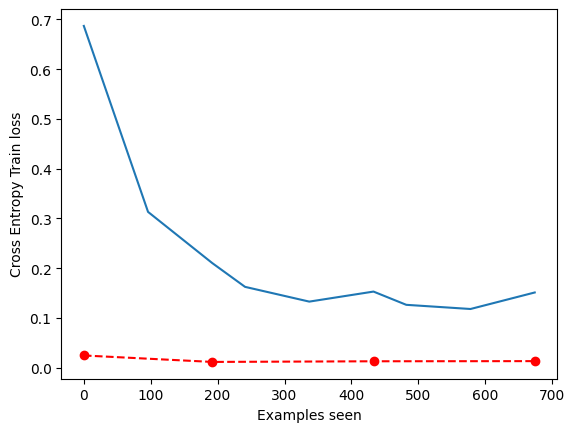

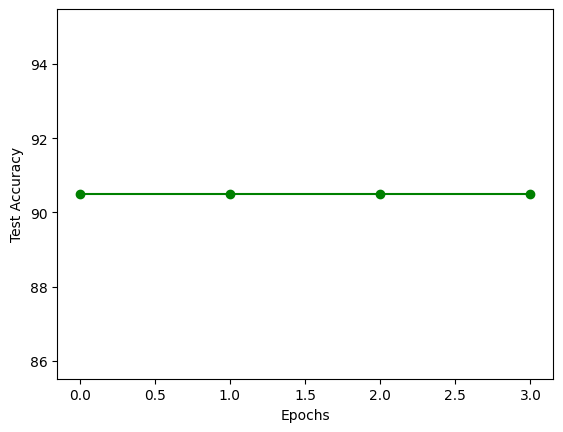

In [15]:
plot_results(test_accuracies, test_losses, train_losses)

# Sanity check  

In [16]:
def visualize_prediction(datapoint, model):
  to_pil = transforms.ToPILImage()
  image = to_pil(datapoint[0])
  plt.imshow(image)

  datapoint = datapoint[0].unsqueeze(0).to(device)

#   title = 'Model Predicts Tuberculosis' if model(datapoint[0]) > 0.5 else 'Model Predicts Healthy'
#   subtitle = '(True label Tuberculosis)' if datapoint[1] else '(True label Healthy)'
#   plt.title(title + '\n' + subtitle)
#   plt.axis('off')
#   plt.show()


# visualize_prediction(dataset_test[0], model)
# visualize_prediction(dataset_test[1], model)
# visualize_prediction(dataset_test[2], model)
# visualize_prediction(dataset_test[3], model)
# visualize_prediction(dataset_test[4], model)
# visualize_prediction(dataset_test[-1], model)
# visualize_prediction(dataset_test[-2], model)
# visualize_prediction(dataset_test[-3], model)
# visualize_prediction(dataset_test[-4], model)
# visualize_prediction(dataset_test[-5], model)